In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import shutil
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers.core import Dense, Dropout, Reshape
from keras.layers import GRU, Input, Concatenate, RepeatVector, Embedding, Lambda
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications import vgg16 as vgg16_model
from keras import objectives
import keras.backend as K

import cv2
import os
import pickle
from datetime import datetime

Using TensorFlow backend.


In [8]:
# dataset_dir = '../Dataset/'
# images_dir = dataset_dir + 'images/'

dataset_dir = '..\Dataset\\'
images_dir = 'C:\MsData\\'

model_name = 'gru_init_state-' + str(datetime.now().date())
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

np.random.seed(42)
word2Index = np.load(dataset_dir + 'wordIndex.npz')['a']

num_epochs = 20
batch_size = 128

input_shape = (224, 224, 3)
max_len = 20
vocab_size = len(word2Index)
print(vocab_size)
print(len(os.listdir(images_dir)))

10326
13117


In [9]:
### Load dataset

def get_sample(sample):
    
    im = cv2.cvtColor(cv2.imread(images_dir+sample['image_id']+'.jpg'), cv2.COLOR_BGR2RGB) # change this back
   # im = cv2.imread(images_dir+sample['image_id']+'.jpg')

    im = cv2.resize(im, (input_shape[0], input_shape[1]))
    im = im / 255.0
    
    wInput = np.array(sample['token_in']).reshape((1,20))

    wOutput = np.zeros((vocab_size,), dtype='int')
    wOutput[sample['token_out']] = 1
    
    return (im, wInput), wOutput
    
def data_generator(df, batch_size):
    indexes = np.arange(0, len(df), batch_size)
    
    # Last value removed to prevent creation of a batch with size < batch_size 
    # incase the dataset can not be divided into the correct number of batches
    # given the predefined batch_size
    # This approach effectively reduces the number of batches by 1
    
    if len(df) % batch_size != 0:
        indexes = indexes[:-1] 
    
    while True: # 1 iteration represents 1 epoch
        np.random.shuffle(indexes) # indexes shuffled for each epoch
        for index in indexes: # 1 iteration represents 1 batch
            batch_examples = df.iloc[index : index+batch_size].reset_index()
                        
            Xim = np.zeros((batch_size, *input_shape))
            Xw  = np.zeros((batch_size, 1, max_len))
            Ys  = np.zeros((batch_size, vocab_size))
            for index, row in batch_examples.iterrows():
                (xim, xw), y = get_sample(row)
                Xim[index, :, :, :] = xim
                Xw[index, :, :] = xw
                Ys[index, :] = y
            yield [Xim, Xw], Ys
            
            

In [10]:
dataset = pd.read_csv(dataset_dir+'full_dataset_indexes.csv').astype('object')
dataset['token_in'] = dataset['token_in'].apply(lambda x: eval(x))
print('Dataset size: ', dataset.shape)

train_set, val_set = train_test_split(dataset, test_size=0.2,random_state = 42)
train_set, test_set = train_test_split(train_set, test_size=0.2, random_state = 37)
print('Training samples:', len(train_set), 'Validation samples:', len(val_set), 'Testing samples:', len(test_set))

train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)

Dataset size:  (397078, 3)
Training samples: 254129 Validation samples: 79416 Testing samples: 63533


In [11]:
### Training
### BUILD MODEL

input_im = Input(shape=(input_shape), name='input_im') # INPUT TO NETWORK - A
vggWeight = '../Weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16 = vgg16_model.VGG16(include_top=True, weights=None, input_tensor=input_im, input_shape=None, classes=1000)
vgg16.load_weights(vggWeight)
vgg16.layers.pop()
for l in vgg16.layers:
    l.trainable = False

image_vec = Dense(512, activation='relu', name='image_vec')(vgg16.layers[-1].output)
image_embedding_model = Model(vgg16.input, image_vec, name='VGG16-features')

enc_im_embedding = image_embedding_model(input_im)
embInput = Input(shape = (1,max_len), name='text_input')
embLayer = Embedding(input_dim = vocab_size, output_dim = 512, name='word_embedding')(embInput)
embLayer = Reshape((max_len,512))(embLayer)

grrn = GRU(512, unroll=True, name='GRU')(embLayer, initial_state=enc_im_embedding)
output_token = Dense(vocab_size, activation='softmax', name='output_token')(grrn)
model = Model(inputs=[input_im, embInput], outputs=output_token)

adam = Adam(lr=2e-5)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 1, 20)        0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 1, 20, 512)   5286912     text_input[0][0]                 
__________________________________________________________________________________________________
input_im (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 20, 512)      0           word_embedding[0][0]             
__________________________________________________________________________________________________
VGG16-feat

In [ ]:
class LRTensorBoard(TensorBoard):
    def __init__(self, log_dir):  # add other arguments to __init__ if you need
        super(LRTensorBoard, self).__init__(log_dir=log_dir)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = LRTensorBoard(log_dir='./'+model_name)
# earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, epsilon=0.03)

# callbacks = [checkpoint, tensorboard, earlystop, cvslogger, reducelr]
callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

In [ ]:
hist = model.fit_generator(train_gen, epochs=num_epochs, steps_per_epoch=len(train_set)//batch_size, 
                           validation_data=val_gen, validation_steps=len(val_set)//batch_size, 
                           callbacks=callbacks, verbose=1)

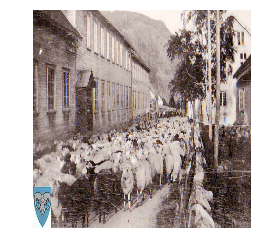

what city is this <end> 


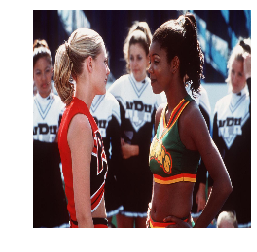

what are they playing <end> 


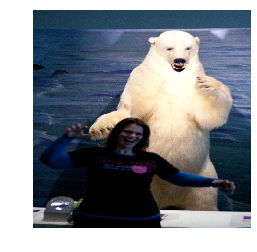

what is the name <end> 


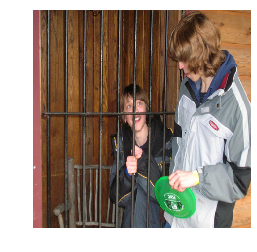

what is the name of the shirt <end> 


In [12]:
model.load_weights('..\Weights\gru_init_state-2018-10-26-20-3.50.h5')

wordlist = word2Index.tolist()
sample = test_gen.__next__()

from math import ceil 

vector = []
for num in range(4):
    current = []

    sampleXimg = sample[0][0][num,:,:,:]
    sampleXwords = sample[0][1][num,:,:]
    sampleY = sample[1][num,:]

    plt.imshow(sampleXimg)
    plt.axis('off')
#     plt.show()

    start_codon = wordlist.index('<start>')
    end_codon = wordlist.index('<end>')

    input_words = np.repeat(end_codon, max_len)
    input_words[0] = start_codon

    finalProb = []
    
    sentence = ''
    for i in range(max_len):
        stuff = [np.array([sampleXimg]), np.array([input_words.reshape(1,max_len)])]
        pred = model.predict(stuff).astype('float64')

        #     pred = np.exp(np.log(pred) / 0.3)
        #     pred /= np.sum(pred)
        #     pred = np.random.multinomial(1, pred.reshape((10326,)), 1)

        current.append(pred)
        
#         pred_1d = pred.reshape(vocab_size,)
#         overflow = pred_1d.sum() - 1
#         shiftby = overflow / len(pred_1d)
#         pred_1d -= shiftby

        pred_index = pred.argmax()
#         pred_index = np.random.choice(np.array(wordlist), p=pred_1d)
        next_word = wordlist[pred_index]
#         print(next_word)
        sentence += next_word + ' '

        if next_word == '<end>' or i == max_len-1:
            break

        input_words[i+1] = pred_index
    plt.show()
    print(sentence)

    vector.append(np.array(current))